A notebook to test ordinal lightgbm

In [1]:
%load_ext autoreload
%autoreload 2
from lightgbm import train, Dataset, LGBMClassifier, record_evaluation
from ordinal_gbt.loss import lgb_loss_factory
from ordinal_gbt.lgb import LGBMOrdinal
from ordinal_gbt.data import simplest_case, make_ordinal_classification
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.datasets import make_regression
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
from functools import partial
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

In [2]:
def per_tree_train_test(X_train,y_train,X_test,y_test,score_fun,model,
                        starting_estimators =1, ending_estimators=100, step_estimators =5):
    d_results = {'estimators':[], 'score':[]}
    prev_model = None
    current_estimators = model.n_estimators 
    while current_estimators < ending_estimators:
        logger.debug(f'Using {current_estimators} estimators.')
        model.fit(X_train,y_train)
        model.n_estimators = step_estimators +current_estimators
        preds = model.predict(X_test)
        score = score_fun(y_true=y_test,y_pred = preds)
        logger.debug(f'Score is {score}')
        current_estimators = model._Booster.current_iteration()
        d_results['estimators'].append(current_estimators)
        d_results['score'].append(score)
    return per_tree_results_to_df( d_results )

def per_tree_results_to_df(results):
    return  pd.DataFrame(results['estimators'],columns=['estimators']).join(pd.DataFrame(results['score']))

In [4]:
X,y = make_ordinal_classification(n_classes=4,n_samples=1000, n_features = 100, n_informative =10,noise=2,
                                  random_state=42)
X_train,X_test, y_train, y_test = train_test_split(X,y,train_size=0.8)

In [5]:
model = LGBMOrdinal(n_estimators=10)
model.fit(X_train,y_train)

LGBMOrdinal(n_estimators=10,
            objective=<function LGBMOrdinal._lgb_loss_factory.<locals>.loss at 0x10afa5430>)

In [31]:
model.n_estimators

10

In [6]:
model = LGBMOrdinal(n_estimators=1)
df_ordinal = per_tree_train_test(X_train,y_train,X_test,y_test,
                                 partial( f1_score, average= None ), model,
                                 step_estimators=10)

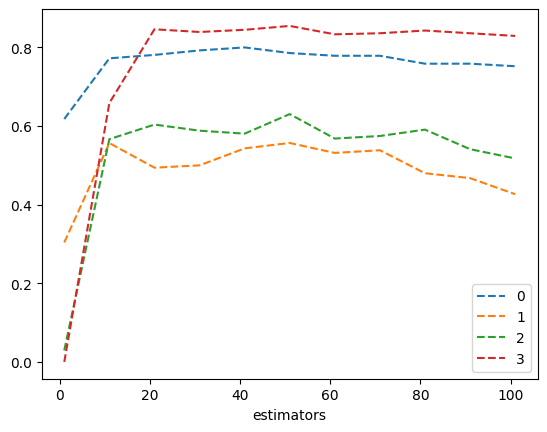

In [7]:
ax = df_ordinal.plot(x='estimators',y = list(range(len(df_ordinal.columns)-1)),linestyle = '--')


# 5 classes 

In [8]:
X,y = make_ordinal_classification(n_classes=5,n_samples=1000, n_features = 100, n_informative =10,noise=2,
                                  random_state=42)
X_train,X_test, y_train, y_test = train_test_split(X,y,train_size=0.8)

In [9]:
model = LGBMClassifier(n_estimators=1)
df_classifier = per_tree_train_test(X_train,y_train,X_test,y_test,partial( f1_score, average= None ), model)

In [12]:
model = LGBMOrdinal(n_estimators=1)
df_ordinal = per_tree_train_test(X_train,y_train,X_test,y_test,partial( f1_score, average= None ), model)

KeyboardInterrupt: 

<Axes: xlabel='estimators'>

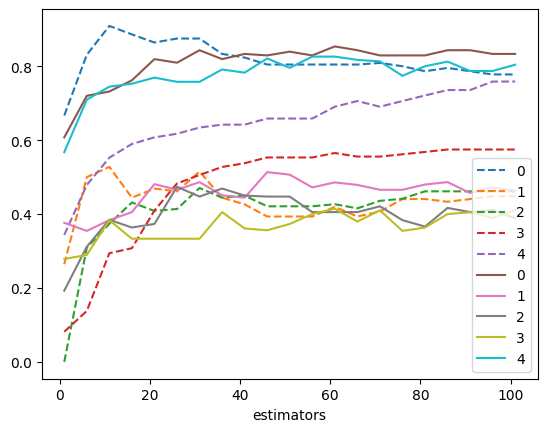

In [11]:
ax = df_ordinal.plot(x='estimators',y = list(range(len(df_ordinal.columns)-1)),linestyle = '--')
df_classifier.plot(x='estimators',y = list(range(len(df_classifier.columns)-1)), linestyle = '-',ax=ax)

In [50]:
y_preds = mord.predict(X_test)
print(classification_report(y_test,np.argmax(y_preds,axis =1)))

              precision    recall  f1-score   support

           0       0.77      0.79      0.78        58
           1       0.51      0.62      0.56        60
           2       0.84      0.70      0.76        82

    accuracy                           0.70       200
   macro avg       0.71      0.70      0.70       200
weighted avg       0.72      0.70      0.71       200



In [47]:
mmult = LGBMClassifier(n_estimators=100)
mmult.fit(X_train,y_train)

LGBMClassifier()

In [48]:
y_preds = mmult.predict(X_test)
print(classification_report(y_test,y_preds))

              precision    recall  f1-score   support

           0       0.70      0.74      0.72        58
           1       0.47      0.42      0.44        60
           2       0.78      0.82      0.80        82

    accuracy                           0.68       200
   macro avg       0.65      0.66      0.65       200
weighted avg       0.67      0.68      0.67       200

